In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


### Importing preprocessed data of New York from previous labs

In [2]:
ny_data=pd.read_csv('NewYork.csv')

In [3]:
ny_data.drop(columns='Unnamed: 0',inplace=True)
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
ny_data.shape

(306, 4)

### Inserting my credentials for Foursquare API

In [5]:
CLIENT_ID = 'QQSV0QMWWO1CPYYR3CVOC2ONQQP2P3L5WVHAYIA2TVDCFHEJ' # your Foursquare ID
CLIENT_SECRET = 'JZXJWSHBDWLBFNV1HD00HQZOENARP4JLMXLOLUAVU1WEZ4TY' # your Foursquare Secret
VERSION = '20200814' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QQSV0QMWWO1CPYYR3CVOC2ONQQP2P3L5WVHAYIA2TVDCFHEJ
CLIENT_SECRET:JZXJWSHBDWLBFNV1HD00HQZOENARP4JLMXLOLUAVU1WEZ4TY


### Defining function to get 100 venues for each neighborhood

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',           
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [7]:
ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )

In [8]:
print('Number of venues categories in New York is',ny_venues['Venue Category'].nunique())

Number of venues categories in New York is 430


In [9]:
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

In [10]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()

### Defining function to get most common venues in each neighborhood based on frequency

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating DataFrame of 10 most common venues in New York neighborhoods

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Discount Store,Breakfast Spot,Fast Food Restaurant,Martial Arts School,Electronics Store,Pharmacy
1,Annadale,Pizza Place,Dance Studio,Train Station,Park,Pharmacy,Restaurant,American Restaurant,Liquor Store,Diner,Fast Food Restaurant
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Pizza Place,Women's Store,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant
3,Arlington,Grocery Store,Deli / Bodega,Liquor Store,Intersection,American Restaurant,Bus Stop,Field,Fish & Chips Shop,Financial or Legal Service,Filipino Restaurant
4,Arrochar,Bus Stop,Pizza Place,Italian Restaurant,Deli / Bodega,Food Truck,Hotel,Outdoors & Recreation,Middle Eastern Restaurant,Liquor Store,Bagel Shop


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

### Checking how many clusters are needed using Silhouette score

In [14]:
from sklearn.cluster import KMeans
max_range = 8

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    nyg = ny_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(nyg)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(nyg, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

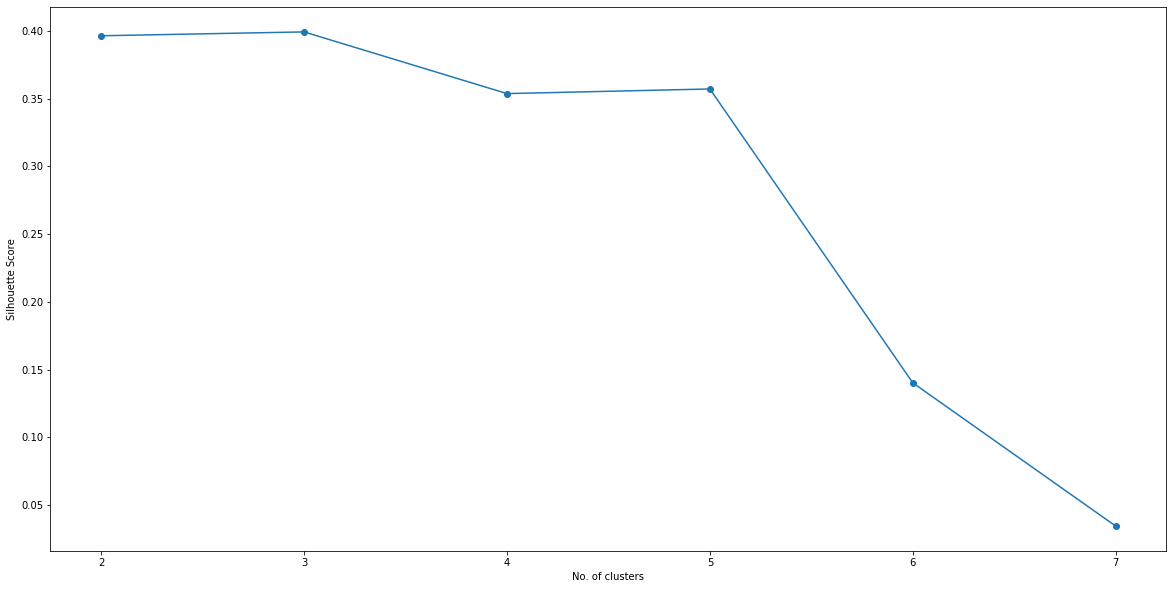

In [15]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Greatest score is for 3 clusters

In [16]:
kmeans = KMeans(n_clusters=3).fit(ny_grouped_clustering)

In [17]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Pharmacy,Gas Station,Donut Shop,Laundromat,Ice Cream Shop,Pizza Place,Food,Dessert Shop,Sandwich Place,Farm
1,Bronx,Co-op City,40.874294,-73.829939,1,Bus Station,Discount Store,Post Office,Grocery Store,Basketball Court,Pizza Place,Pharmacy,Bagel Shop,Fast Food Restaurant,Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,1,Deli / Bodega,Bus Station,Caribbean Restaurant,Bus Stop,Diner,Convenience Store,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant,Automotive Shop
3,Bronx,Fieldston,40.895437,-73.905643,1,Plaza,River,Bus Station,Women's Store,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
4,Bronx,Riverdale,40.890834,-73.912585,1,Bus Station,Park,Bank,Medical Supply Store,Food Truck,Home Service,Plaza,Baseball Field,Gym,Filipino Restaurant


#### Checking how many neighborhoods are in each cluster.

In [18]:
ny_merged['Cluster Labels'].value_counts()

1    300
0      5
2      1
Name: Cluster Labels, dtype: int64

#### Checking distibution of clusters in Bronx neigborhood.

In [19]:
ny_merged[ny_merged['Borough']=='Bronx']['Cluster Labels'].value_counts()

1    51
0     1
Name: Cluster Labels, dtype: int64

### Analysing what is first and second most common venue in clusters 0 and 1

In [20]:
ny_cluster_0=ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
ny_cluster_0['1st Most Common Venue'].value_counts()

Park          3
Playground    1
Trail         1
Name: 1st Most Common Venue, dtype: int64

In [21]:
ny_cluster_0['2nd Most Common Venue'].value_counts()

Women's Store                2
Park                         1
South American Restaurant    1
Bagel Shop                   1
Name: 2nd Most Common Venue, dtype: int64

In [23]:
ny_cluster_1=ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
ny_cluster_1['1st Most Common Venue'].value_counts()

Pizza Place            28
Italian Restaurant     28
Deli / Bodega          25
Coffee Shop            17
Bar                    13
                       ..
Spanish Restaurant      1
Rental Car Location     1
Thai Restaurant         1
Arts & Crafts Store     1
Lounge                  1
Name: 1st Most Common Venue, Length: 77, dtype: int64

In [24]:
ny_cluster_1['2nd Most Common Venue'].value_counts()

Pizza Place                24
Italian Restaurant         19
Deli / Bodega              19
Coffee Shop                12
Bank                       10
                           ..
Baseball Field              1
Department Store            1
New American Restaurant     1
Athletics & Sports          1
Breakfast Spot              1
Name: 2nd Most Common Venue, Length: 100, dtype: int64

## Repeating whole process for Toronto Neighborhood

Data preprocessed in previous labs and now only downloaded.

In [25]:
toronto_data=pd.read_csv('Torontocoordinates.csv')

In [26]:
toronto_data.drop(columns='Unnamed: 0',inplace=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [27]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [28]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(2139, 269)

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
for hood in toronto_grouped['Neighborhood']:
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Breakfast Spot,Latin American Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Ethiopian Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Sandwich Place,Dance Studio,Pharmacy,Pub,Gym,Airport Lounge,College Gym,Ethiopian Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sushi Restaurant,Convenience Store,Deli / Bodega,Supermarket,Middle Eastern Restaurant,Restaurant,Mobile Phone Shop,Pizza Place
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Hobby Shop,Liquor Store,Japanese Restaurant,Indian Restaurant,Pub,Butcher


In [31]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

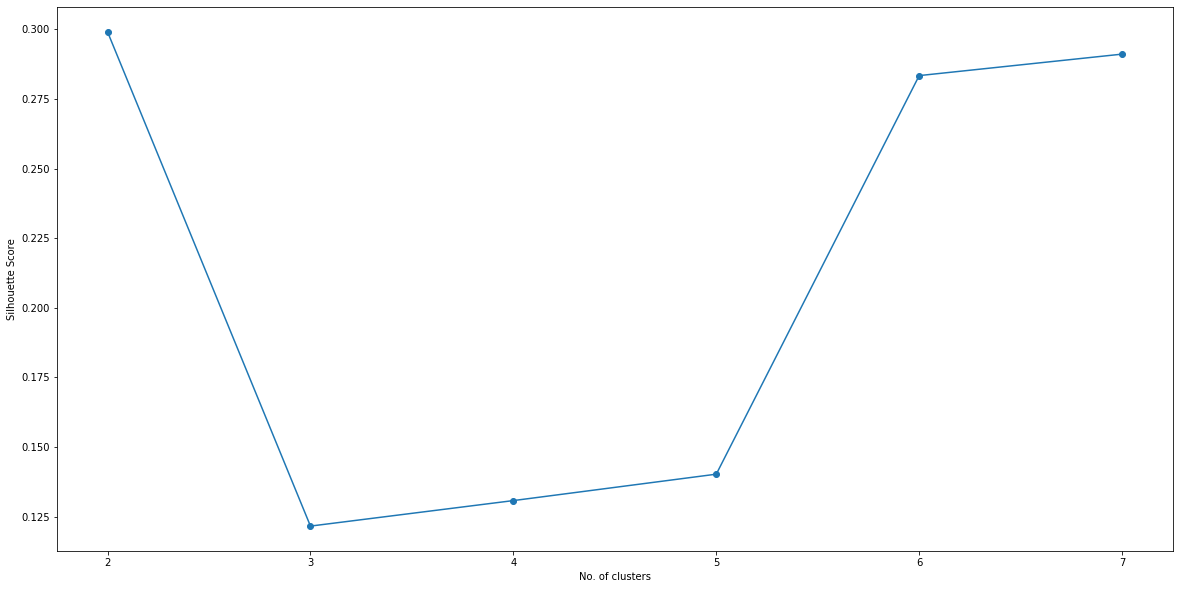

In [32]:
indices = []
scores = []
for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    torg = toronto_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(torg)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(torg, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [45]:
tor_kmeans= KMeans(n_clusters=2).fit(toronto_grouped_clustering)

In [47]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', tor_kmeans.labels_)


toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Event Space
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Intersection,Pizza Place,Portuguese Restaurant,French Restaurant,Hockey Arena,Women's Store,Discount Store,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Café,Restaurant,Breakfast Spot,Theater,Gym / Fitness Center,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Clothing Store,Accessories Store,Event Space,Vietnamese Restaurant,Coffee Shop,Boutique,Dog Run,Dim Sum Restaurant,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,College Cafeteria,Yoga Studio,Beer Bar,Sushi Restaurant,Bank,Bar,Café,Portuguese Restaurant,Diner


In [48]:
toronto_merged['Cluster Labels'].value_counts()

0.0    86
1.0    11
Name: Cluster Labels, dtype: int64

In [49]:
tor_cluster_0=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [50]:
tor_cluster_0['1st Most Common Venue'].value_counts()

Coffee Shop                      18
Pizza Place                       5
Park                              5
Grocery Store                     4
Café                              4
Sandwich Place                    3
Clothing Store                    3
Trail                             3
Fast Food Restaurant              3
Lounge                            2
Bakery                            2
Bar                               2
Gym                               2
Hotel                             1
Convenience Store                 1
Japanese Restaurant               1
General Entertainment             1
Drugstore                         1
Fried Chicken Joint               1
Gym / Fitness Center              1
Indian Restaurant                 1
Motel                             1
Medical Center                    1
Furniture / Home Store            1
Pool                              1
Construction & Landscaping        1
Board Shop                        1
Mexican Restaurant          

In [51]:
tor_cluster_0['2nd Most Common Venue'].value_counts()

Coffee Shop              13
Café                      9
Grocery Store             4
Pub                       3
Chinese Restaurant        3
Women's Store             2
Italian Restaurant        2
Bakery                    2
Skating Rink              2
Vietnamese Restaurant     2
Garden Center             2
Sandwich Place            2
Baseball Field            2
Pharmacy                  2
Breakfast Spot            2
Restaurant                2
Gift Shop                 1
Japanese Restaurant       1
Doner Restaurant          1
Golf Course               1
Jewelry Store             1
Clothing Store            1
Field                     1
Electronics Store         1
Beer Store                1
Hotel                     1
Indian Restaurant         1
Intersection              1
Discount Store            1
Asian Restaurant          1
Aquarium                  1
American Restaurant       1
Bus Line                  1
Pizza Place               1
Curling Ice               1
Bank                

In [52]:
tor_cluster_1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [53]:
tor_cluster_1['1st Most Common Venue'].value_counts()

Park          10
Smoke Shop     1
Name: 1st Most Common Venue, dtype: int64

In [54]:
tor_cluster_1['2nd Most Common Venue'].value_counts()

Convenience Store             3
Construction & Landscaping    1
Food & Drink Shop             1
River                         1
Pool                          1
Swim School                   1
Asian Restaurant              1
Playground                    1
Bus Line                      1
Name: 2nd Most Common Venue, dtype: int64

### Providing map of clusters in Toronto

In [55]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

In [56]:
address = 'Toronto, Ca'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [66]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=3
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters